In [1]:
# Analysing initial outputs from Maggie's game
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy as ent
import pyphi
import time
import math

import sys
sys.path.insert(0, '/Users/bjornjuel/projects/actual_agency_fork/')

from pyanimats import *
from actual_agency import *
import pyphi

pyphi.config.VALIDATE_SUBSYSTEM_STATES = False
pyphi.config.PARTITION_TYPE = 'TRI'

%load_ext autoreload
%autoreload 2


Welcome to PyPhi!

If you use PyPhi in your research, please cite the paper:

  Mayner WGP, Marshall W, Albantakis L, Findlay G, Marchman R, Tononi G.
  (2018). PyPhi: A toolbox for integrated information theory.
  PLOS Computational Biology 14(7): e1006343.
  https://doi.org/10.1371/journal.pcbi.1006343

Documentation is available online (or with the built-in `help()` function):
  https://pyphi.readthedocs.io

To report issues, please use the issue tracker on the GitHub repository:
  https://github.com/wmayner/pyphi

For general discussion, you are welcome to join the pyphi-users group:
  https://groups.google.com/forum/#!forum/pyphi-users

To suppress this message, either:
  - Set `WELCOME_OFF: true` in your `pyphi_config.yml` file, or
  - Set the environment variable PYPHI_WELCOME_OFF to any value in your shell:
        export PYPHI_WELCOME_OFF='yes'



In [156]:
# some functions for generating TPM and activity pattern for toy systems
def gen_cm(n_hidden,n_motors,n_sensors,p_connection=0.5,p_excitatory=0.5,w=None):
    
    n_nodes = n_hidden + n_sensors + n_motors
    # first, indicate the node types (excitatory (+1) or inhibitory (-1))
    node_types = 2*(np.random.rand(n_nodes) < p_excitatory) - 1
    
    # next, produce binary CM to indicate wether or not there is a connection
    connection = np.random.rand(n_nodes,n_nodes) < p_connection
    
    # then, set synaptic weights for individual connections
    if w == None:
        w = np.ones((n_nodes,n_nodes))/np.sqrt(n_nodes*p_connection)
    elif type(w) == int or type(w) == float:
        w = np.ones((n_nodes,n_nodes))*w
        
    
    # finally, produce CM
    cm = np.array([[w[i,j]*node_types[j]*connection[i,j] for i in range(n_nodes)] for j in range(n_nodes)])
    cm[:,:n_sensors] = 0
    cm[n_sensors:n_sensors+n_motors,:] = 0
    
    cm = np.around(cm,decimals=2)
    
    return cm

def get_states(n_nodes):
    return np.array(([list(('{:0'+str(n_nodes)+'d}').format(int(bin(x)[2:]))) for x in range(2**n_nodes)])).astype(int)

def next_state(cm,activation,state):
    
    node_input = np.matmul(state,cm)
    
    if activation == 'sigmoid':
        p_activation = [sigmoid(i) for i in node_input]
        
    elif activation == 'deterministic':
        p_activation = [1 if i>0 else 0 for i in node_input]
        
    return p_activation


def sample_tpm(cm,activation):
    
    nodes = cm.shape[0]
    next_states = np.zeros((2**nodes,nodes))
    states = get_states(nodes)
    
    for state,row in zip(states,range(2**nodes)):
        next_states[row,:] = next_state(cm,activation,state)
            
    return next_states


def gen_tpm(n_hidden,n_motors,n_sensors,p_connection=0.5,p_excitatory=0.5,w=None,activation = 'sigmoid'):
    
    total_nodes = n_sensors + n_hidden+ n_motors
    
    # generate a CM
    cm = gen_cm(n_hidden,n_motors,n_sensors,p_connection,p_excitatory,w)
    
    # Generates TPM for the agent.
    
    tpm = sample_tpm(cm,activation)
    
    tpm = pyphi.convert.to_multidimensional(tpm)

    return tpm,cm


def sigmoid(x,slope=1,center=0):
    return 1 / (1 + math.exp(-slope*(x-center)))

def gen_BrainActivity(animat,trials,times,initial_state = None):
    tpm = animat.brain.tpm
    
    if initial_state == None:
        initial_state = np.random.randint(0,2,(trials,animat.n_nodes))
    elif len(initial_state)==animat.n_nodes:
        initial_state = np.matlib.repmat(initial_state,trials,1)
    elif not len(initial_state) == trials:
        print("randomizing intiial states as one was not defined for each trial")
        initial_state = np.random.randint(0,2,(trials,animat.n_nodes))
        
    threshold = np.random.rand(trials,times,animat.n_nodes)
    brain_activity = np.zeros((trials,times,animat.n_nodes))
    
    for trial in range(trials):
        brain_activity[trial,0,:] = initial_state[trial,:]
        for time in range(1,times):
            p_activation = tpm[tuple(brain_activity[trial,time-1,:].astype(int))]
            next_state = [1 if p>t else 0 for p,t in zip(p_activation,threshold[trial,time,:])]
            brain_activity[trial,time,:] = next_state
            
    return brain_activity.astype(int)
    

def save_phi_from_MCs(animat):
    '''

        Inputs:

        Outputs:
    '''

    phis = []
    for s in animat.unique_states:

        if animat.MCs[state2num(s)] == None:
            phis.append(0)
        else:
            phis.append(animat.MCs[state2num(s)].phi)
    animat.phis = phis


def calc_effective_information(tpm,n_nodes):
    
    shp = tpm.shape
    # chacking that tpm is in state by state
    if not len(shp) == 2:
        tpm = pyphi.convert.to_2dimensional(tpm)
        tpm = pyphi.convert.state_by_node2state_by_state(tpm)
    if len(shp) == 2 and not shp[0] == shp[1]:
        tpm = pyphi.convert.state_by_node2state_by_state(tpm)
        
    determinism = np.mean([np.log2(2**n_nodes) - ent(tp) for tp in tpm]) # expected_entropy_of_out_weights
    degeneracy = np.log2(2**n_nodes) - ent(np.mean(tpm,0))
    
    return determinism - degeneracy


In [65]:
# creating an animat
n_sensors = 1
n_hidden = 4
n_motors = 1
animat = Animat({'hiddenNodes' : n_hidden, 'nrOfLeftSensors' : 1, 'nrOfRightSensors' : 0, 'motorNodes' : 1})
tpm,cm = gen_tpm(n_hidden,n_motors,n_sensors,p_connection=0.8,p_excitatory=0.8,w=1)
animat.saveBrain(tpm,np.ceil(np.abs(cm)))

In [ ]:
# running analysis over multiple random networks
# setting parameters
n_sensors = 1
n_hidden = 4
n_motors = 1
trials = 3
times = 20

data = pd.DataFrame(columns=['p_conn','p_ex','animat','unique_states','unique_transitions',
                            'phi_max','phi_mean','non-zero_states','mean_complex_size',
                             'mean_alpha_motor_direct','size_purview_motor_direct',
                             'mean_alpha_complex_direct','size_purview_motor_direct',
                             'mean_alpha_motor_backtrack','size_purview_motor_backtrack',
                             'mean_alpha_complex_backtrack','size_purview_motor_backtrack',
                             'hiddenratio_direct_motor','hiddenratio_direct_MC',
                             'hiddenratio_backtrack_motor','hiddenratio_backtrack_MC',
                             'duration_backtrack_motor','duration_backtrack_MC',
                             'MCcause_MC_overlaps','motorcause_MC_overlap'])

# looping over connectivity properties
p_connection = [0.2, 0.4, 0.6, 0.8, 1.0]
p_excitatory = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
repetitions = 10
for c in p_connection:
    for e in p_excitatory:
        for r in range(reps):
            # creating the animat
            animat = Animat({'hiddenNodes' : n_hidden, 
                 'nrOfLeftSensors' : n_sensors, 
                 'nrOfRightSensors' : 0, 
                 'motorNodes' : n_motors})
            tpm,cm = gen_tpm(n_hidden,n_motors,n_sensors,p_connection=c,p_excitatory=p,w=1)
            animat.saveBrain(tpm,np.ceil(np.abs(cm)))
            
            # creating brain activity from TPM
            animat.saveBrainActivity(gen_BrainActivity(animat,trials,times))
            
            # finding and saving unique states and transitions
            animat.saveUniqueTransitions()
            animat.saveUniqueStates()
            
            # calculating IIT parameters for all unique states 
            pyphi.config.PROGRESS_BARS=False
            animat.save_major_complex()
            
            # calculating AC parameters for unique transitions
            animat.save_unique_causal_links()
            
            # saving phis
            save_phi_from_MCs(animat)
            
            # getting the dynamic evolution of the complexes
            history = history_of_complexes(animat,only_state_changes=False)
            
            # calculating the causal history of the complexes...
            MC_cause = get_causal_history(animat, 0,MC=True)
            
            # ... and of the motor states
            MC_cause = get_causal_history(animat, 0,MC=False)
            
            # get backtracking for motor ...
            backtrack_cause_enumerated(animat, trial, t, ocurrence_ixs, max_backsteps=3, purview_type='union', debug=False)
                
            # ... and MC
            backtrack_cause_enumerated(animat, trial, t, ocurrence_ixs, max_backsteps=3, purview_type='union', debug=False)
            
            # getting the overlaps between complex and cause purviews for motor states ...
            occ = (2,3)
            overlaps_motor = [get_complex_purview_overlap(animat,trans,occ) for trans in animat.unique_transitions]
            
            # ... and the complex itself
            overlaps_MC = [get_complex_purview_overlap(animat,trans,'MC') for trans in animat.unique_transitions]
            
            # creating structure to add to dataframe

In [159]:
# creating brain activity from TPM
animat.saveBrainActivity(gen_BrainActivity(animat,3,20))


In [163]:
animat.brain_activity

array([[[1, 1, 1, 1, 1, 0],
        [0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1],
        [0, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1],
        [0, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 1, 1],
        [0, 1, 0, 0, 1, 1],
        [1, 1, 0, 0, 1, 1],
        [1, 1, 0, 0, 1, 1],
        [0, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1]],

       [[1, 1, 0, 1, 1, 0],
        [1, 0, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1],
        [0, 1, 1, 0, 1, 1],
        [0, 1, 1, 1, 1, 1],
        [0, 1, 1, 0, 0, 1],
        [0, 1, 0, 1, 1, 1],
        [0, 0, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0, 0],
        [1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1],
        [1, 1, 0, 

In [160]:
# finding and saving unique states and transitions
animat.saveUniqueTransitions()
animat.saveUniqueStates()

In [161]:
# calculating IIT parameters for all unique states 
pyphi.config.PROGRESS_BARS=False
animat.save_major_complex()

Finding MC for state number 0 out of 18 unique states
Finding MC for state number 1 out of 18 unique states
Finding MC for state number 2 out of 18 unique states
Finding MC for state number 3 out of 18 unique states
Finding MC for state number 4 out of 18 unique states
Finding MC for state number 5 out of 18 unique states
Finding MC for state number 6 out of 18 unique states
Finding MC for state number 7 out of 18 unique states
Finding MC for state number 8 out of 18 unique states
Finding MC for state number 9 out of 18 unique states
Finding MC for state number 10 out of 18 unique states
Finding MC for state number 11 out of 18 unique states
Finding MC for state number 12 out of 18 unique states
Finding MC for state number 13 out of 18 unique states
Finding MC for state number 14 out of 18 unique states
Finding MC for state number 15 out of 18 unique states
Finding MC for state number 16 out of 18 unique states
Finding MC for state number 17 out of 18 unique states


In [162]:
# calculating AC parameters for unique transitions
animat.save_unique_causal_links()

Finding causes for transition number 0 out of 41 unique transitions
Finding causes for transition number 1 out of 41 unique transitions
Finding causes for transition number 2 out of 41 unique transitions
Finding causes for transition number 3 out of 41 unique transitions
Finding causes for transition number 4 out of 41 unique transitions
Finding causes for transition number 5 out of 41 unique transitions
Finding causes for transition number 6 out of 41 unique transitions
Finding causes for transition number 7 out of 41 unique transitions
Finding causes for transition number 8 out of 41 unique transitions
Finding causes for transition number 9 out of 41 unique transitions
Finding causes for transition number 10 out of 41 unique transitions
Finding causes for transition number 11 out of 41 unique transitions
Finding causes for transition number 12 out of 41 unique transitions
Finding causes for transition number 13 out of 41 unique transitions
Finding causes for transition number 14 out 

In [71]:
save_phi_from_MCs(animat)

In [72]:
history = history_of_complexes(animat,only_state_changes=False)

In [73]:
MC_cause = get_causal_history(animat, 0,MC=True)

In [74]:
MC_cause

[(0, 2, 4),
 (0, 2, 3, 4),
 (0, 2, 3, 4),
 (0, 3, 4),
 (0, 2, 3, 4),
 (0, 2, 3, 4),
 (0, 2, 3, 4),
 (),
 (0, 3, 4),
 (0, 3, 4),
 (0, 3, 4),
 (0, 2, 3, 4),
 (),
 (0, 3, 4),
 (0, 3, 4),
 (0, 3, 4),
 (0, 2, 3, 4),
 (0, 2, 3, 4),
 (0, 2, 3, 4)]

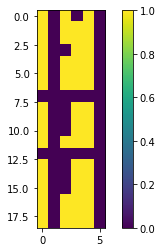

In [76]:

complex_cause_history = [[1 if i in cause else 0 for i in range(animat.n_nodes)] for cause in MC_cause]
plt.imshow(complex_cause_history)
plt.colorbar()

In [81]:
animat.MCs[19].phi

0.115903

In [82]:
occ = (2,3)
overlaps = [get_complex_purview_overlap(animat,trans,occ) for trans in animat.unique_transitions]

In [83]:
overlaps

[0.25,
 0.5,
 0.5,
 0.25,
 0.5,
 0.5,
 0.5,
 0,
 0.25,
 0.25,
 0.25,
 0,
 0.25,
 0.25,
 0.5,
 0.5,
 0.5]

In [84]:
get_union_of_causes(animat,animat.unique_transitions[0],(2,3))

(0, 2, 4)

In [85]:
ba = np.vstack((animat.brain_activity,animat.brain_activity))

In [86]:
t = animat.unique_transitions[0]

In [87]:
animat.unique_transitions.index(t)

0

In [88]:
cm

array([[ 0.,  1.,  1.,  0.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  1.,  1.],
       [ 0., -0., -1., -1., -1., -0.],
       [ 0.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  1.]])

In [89]:

with open('animat.pkl', 'wb') as f:
    pickle.dump(animat, f, pickle.HIGHEST_PROTOCOL)

In [90]:

with open('animat.pkl', 'rb') as f:
    animat = pickle.load(f)

In [91]:
overlaps = [get_complex_purview_overlap(animat,trans,'MC') for trans in animat.unique_transitions] 

In [92]:
overlaps

[0.25,
 0.5,
 0.5,
 0.25,
 0.5,
 0.5,
 0.5,
 0,
 0.25,
 0.25,
 0.25,
 0,
 0.25,
 0.25,
 0.5,
 0.5,
 0.5]

In [ ]:
import json

with open('/Users/bjornjuel/Downloads/network.json') as json_file:
    data = json.load(json_file)


pyphi.network.Network.from_json(data)

In [ ]:
tpm = data['tpm']

In [ ]:
pyphi.convert.state_by_node2state_by_state(tpm)

In [ ]:
net = pyphi.Network(tpm,node_labels=['A','B','C'])
state = data['state']

In [ ]:
sia = pyphi.compute.complexes(net,state)
len(sia)
sia[1]

In [ ]:
sub = pyphi.subsystem.Subsystem(net,state,nodes=(0,1,))
sub.tpm

In [ ]:
pyphi.convert.state_by_node2state_by_state(net.tpm)

In [ ]:
def score_from_fitness(fitness):
    return math.exp(fitness*5)-1

In [ ]:
a = [score_from_fitness(a) for a in np.linspace(0,1,101)]
plt.plot(a)

In [ ]:
score_from_fitness(1)

In [ ]:
def num2state2(num,n_nodes):
    '''
    Function description
        Inputs:
            inputs:
        Outputs:
            outputs:
    '''

    number = '{0:0' + str(n_nodes) + 'b}'
    state = number.format(num)
    state = [int(i) for i in state]

    # returns the state
    return state

In [ ]:
num2state(9,8)

In [ ]:
state2num(tuple([1, 0, 0, 1, 0, 0, 0, 0]))

In [ ]:
a.reverse()
print(a)

In [ ]:
# Operating System List
os = ['Windows', 'macOS', 'Linux']
print('Original List:', os)

# List Reverse
os.reverse()

# updated list
print('Updated List:', os)

In [104]:
def count_repetations(l):
    count = 0
    for i in range(1,len(l)):
        if l[i] == l[i-1]:
            count += 1
            
    return count

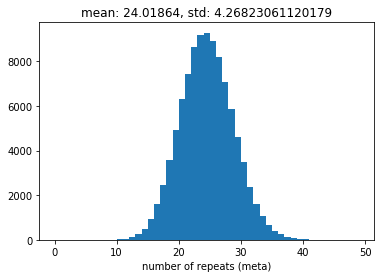

In [134]:
origlist = [i%4 for i in range(100)]
repetitions = []
for i in range(100000):
    np.random.shuffle(origlist)
    repetitions.append(count_repetations(origlist))
    
plt.hist(repetitions,bins=list(range(50)))
plt.title('mean: {}, std: {}'.format(np.mean(repetitions),np.std(repetitions)))
plt.xlabel('number of repeats (meta)')
plt.savefig('expected_repetitions.pdf')

Text(0.5, 1.0, 'mean: 23.9905, std: 4.2850682316621285')

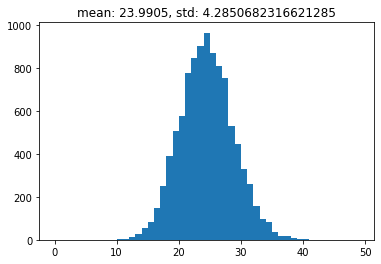

In [110]:
a